In [1]:
import matplotlib.pylab as plt
import numpy as np
import glob
from scipy.interpolate import UnivariateSpline
import shapely
from shapely.geometry import LineString, Point
from scipy.interpolate import interp1d
from scipy.spatial.distance import pdist, squareform
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import copy
import pandas as pd
%config InlineBackend.figure_format = 'retina'
!mkdir -p figures tables
atm_to_gpa=0.000101325
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
def intersection_point(gibbs_line1,gibbs_line2):
    line1 = LineString(gibbs_line1)
    line2 = LineString(gibbs_line2)
    int_pt = line2.intersection(line1)
    if int_pt.geom_type == 'Point':
        point_of_intersection = int_pt.x, int_pt.y
    else:
        int_pt=int_pt[0]
        point_of_intersection = int_pt.x, int_pt.y

    return point_of_intersection

In [3]:
def load_gibbs(fold,sort='P'):
    PT_IceIh_Liquid=glob.glob(fold+'/*_*_*')
    PT_IceIh_Liquid=[[int(a.split('/')[-1].split('_')[0]),float(a.split('/')[-1].split('_')[1]),float(a.split('/')[-1].split('_')[2])]  for a in PT_IceIh_Liquid]
    PT_IceIh_Liquid=np.array(PT_IceIh_Liquid)

    PT_IceIh_Liquid=PT_IceIh_Liquid[np.argsort(PT_IceIh_Liquid[:,0])]

    index_0=np.where(PT_IceIh_Liquid[:,0]==0)[0][0]
    
    PT_IceIh_Liquid=np.concatenate((PT_IceIh_Liquid[index_0::-4][::-1],PT_IceIh_Liquid[index_0::4][1:]),axis=0)

    PT_IceIh_Liquid=PT_IceIh_Liquid[:,1:]

    return PT_IceIh_Liquid

## Load simulation data

In [4]:
color_dict={'pd': '#e41a1c','vega1':'#377eb8','vega2':'#4daf4a','exp':'k','IceIh':'#984ea3','IceII':'#ff7f00','IceIII':'#999999','IceV':'#a65628','IceVI':'#f781bf'}
#color_dict={'pd': 'r','vega1':'b','vega2':'crimson','exp':'k','IceIh':'tab:orange','IceII':'g','IceIII':'c','IceV':'y','IceVI':'m'}

color_dict_lines={'IceIh_Liquid':color_dict['IceIh'],'IceII_Liquid':color_dict['IceII'],
                  'IceIII_Liquid':color_dict['IceIII'],'IceV_Liquid':color_dict['IceV'],
                  'IceVI_Liquid':color_dict['IceVI'],'IceVI_IceV':color_dict['IceVI'],
                 'IceII_IceVI':color_dict['IceII'],'IceII_IceIh':color_dict['IceII'],
                'IceII_IceIII':color_dict['IceIII'],'IceV_IceIII':color_dict['IceV'],
                  'IceIh_IceIII':color_dict['IceIh'],'IceII_IceV':color_dict['IceIh'],'IceII_IceVI_v2':color_dict['IceVI'],'IceII_IceV_v2':color_dict['IceV']}
ls_dict_lines={'IceIh_Liquid':'-','IceII_Liquid':'-',
                  'IceIII_Liquid':'-','IceV_Liquid':'-',
                  'IceVI_Liquid':'-','IceVI_IceV':'--',
                 'IceII_IceVI':'--','IceII_IceIh':'-.',
                'IceII_IceIII':'--','IceV_IceIII':'--',
                  'IceIh_IceIII':'--','IceII_IceV':'-.',
                  'IceII_IceVI_v2':'-.','IceII_IceV_v2':'-.'}


MeltingPoints=dict()
MeltingPoints['IceIh_Liquid']=np.loadtxt('../IceIh-Liquid/4-BiasedCoexistence/P_T.dat')
MeltingPoints['IceII_Liquid']=np.loadtxt('../IceII-Liquid/5-BiasedCoexistence/P_T.dat')
MeltingPoints['IceIII_Liquid']=np.loadtxt('../IceIII-Liquid/5-BiasedCoexistence//P_T.dat')
MeltingPoints['IceV_Liquid']=np.loadtxt('../IceV-Liquid/4-BiasedCoexistence/P_T.dat')
MeltingPoints['IceVI_Liquid']=np.loadtxt('../IceVI-Liquid/5-BiasedCoexistence//P_T.dat')



GibbsLines=dict()
GibbsLines['IceIh_Liquid']=load_gibbs('../GibbsDuhemSimulations/IceIh_Liquid/*/')
GibbsLines['IceIII_Liquid']=load_gibbs('../GibbsDuhemSimulations/IceIII_Liquid/2000.0atm_257.0K/')
GibbsLines['IceIII_Liquid']=GibbsLines['IceIII_Liquid'][GibbsLines['IceIII_Liquid'][:,1]<10000]
GibbsLines['IceVI_Liquid']=load_gibbs('../GibbsDuhemSimulations/IceVI_Liquid/*/')
GibbsLines['IceV_Liquid']=load_gibbs('../GibbsDuhemSimulations/IceV_Liquid/7000.0atm_258.4K/')
GibbsLines['IceV_Liquid']=GibbsLines['IceV_Liquid'][GibbsLines['IceV_Liquid'][:,1]<10000]
GibbsLines['IceII_Liquid']=load_gibbs('../GibbsDuhemSimulations/IceII_Liquid/2000*/')
GibbsLines['IceII_IceIh']=load_gibbs('../GibbsDuhemSimulations/IceII_IceIh/*/')
GibbsLines['IceVI_IceV']=load_gibbs('../GibbsDuhemSimulations/IceVI_IceV/*/',sort='T')
GibbsLines['IceV_IceIII']=load_gibbs('../GibbsDuhemSimulations/IceV_IceIII/*/',sort='T')
GibbsLines['IceIh_IceIII']=load_gibbs('../GibbsDuhemSimulations/IceIh_IceIII/*/',sort='T')
GibbsLines['IceII_IceIII']=load_gibbs('../GibbsDuhemSimulations/IceII_IceIII/7*/',sort='P')
GibbsLines['IceII_IceV']=load_gibbs('../GibbsDuhemSimulations/IceII_IceV/*/',sort='T')
GibbsLines['IceII_IceVI']=load_gibbs('../GibbsDuhemSimulations/IceII_IceVI/*',sort='T')


for key in MeltingPoints.keys():
    MeltingPoints[key][:,0]=MeltingPoints[key][:,0]*atm_to_gpa
for key in GibbsLines.keys():
    GibbsLines[key][:,1]=GibbsLines[key][:,1]*atm_to_gpa

## Load Reference data

In [5]:
tip4p_vega_data=np.genfromtxt('../ReferenceData/tip4p_iceIh+III_liquid_FE.dat')
tip4p_vega_data[:,1]=tip4p_vega_data[:,1]*10*0.986923*atm_to_gpa
tip4p_vega_data2=np.genfromtxt('../ReferenceData/tip4p_iceIh+III_liquid_DC.dat')
tip4p_vega_data2[:,1]=tip4p_vega_data2[:,1]*1000*0.986923 *atm_to_gpa
tip4p_vega_data2=tip4p_vega_data2[np.argsort(tip4p_vega_data2[:,1])]


k = 3
X=tip4p_vega_data
N=len(X)
# matrix of pairwise Euclidean distances
coord=X.copy()
coord[:,0]=coord[:,0]/175.
coord[:,1]=coord[:,1]/(10000.*atm_to_gpa)

distmat = squareform(pdist(coord, 'euclidean'))
neighbors = np.sort(np.argsort(distmat, axis=1)[:, 0:k])
coordinates = np.zeros((N, k, 2, 2))
for i in np.arange(N):
    for j in np.arange(k):
        coordinates[i, j, :, 0] = np.array([X[i,:][0], X[neighbors[i, j], :][0]])
        coordinates[i, j, :, 1] = np.array([X[i,:][1], X[neighbors[i, j], :][1]])

lines_tip4p_vega_data = LineCollection(coordinates.reshape((N*k, 2, 2)),label='Vega TIP4P/ice/free', color=color_dict['vega1'],zorder=0,lw=0.75)

exp_liq=np.genfromtxt('../ReferenceData/Salzmann.dat')
exp_liq=exp_liq[:,::-1]
k = 3
X=exp_liq
N=len(X)
# matrix of pairwise Euclidean distances
coord=X.copy()
coord[:,0]=coord[:,0]/200.
coord[:,1]=coord[:,1]/10000.

distmat = squareform(pdist(coord, 'euclidean'))
neighbors = np.sort(np.argsort(distmat, axis=1)[:, 0:k])
coordinates = np.zeros((N, k, 2, 2))
for i in np.arange(N):
    for j in np.arange(k):
        coordinates[i, j, :, 0] = np.array([X[i,:][0], X[neighbors[i, j], :][0]])
        coordinates[i, j, :, 1] = np.array([X[i,:][1], X[neighbors[i, j], :][1]])

lines_exp_liq = LineCollection(coordinates.reshape((N*k, 2, 2)),label='Vega TIP4P/ice/free', color=color_dict['exp'],zorder=0)



### Determine triple points

In [6]:
trip_pts={}
trip_pts['Liquid IceIII IceV']= intersection_point(GibbsLines['IceIII_Liquid'],GibbsLines['IceV_Liquid'])
trip_pts['Liquid IceIh IceII']= intersection_point(GibbsLines['IceIh_Liquid'],GibbsLines['IceII_Liquid'])
trip_pts['Liquid IceV IceVI']= intersection_point(GibbsLines['IceV_Liquid'],GibbsLines['IceVI_Liquid'])
trip_pts['Liquid IceIII IceIh']= intersection_point(GibbsLines['IceIII_Liquid'],GibbsLines['IceIh_Liquid'])
trip_pts['IceII IceIh IceIII']= intersection_point(GibbsLines['IceII_IceIII'],GibbsLines['IceII_IceIh'])
trip_pts['IceII IceIII IceV']= intersection_point(GibbsLines['IceV_IceIII'],GibbsLines['IceII_IceV'])
trip_pts['IceII IceV IceVI']= intersection_point(GibbsLines['IceII_IceV'],GibbsLines['IceVI_IceV'])
trip_pts['Liquid IceII IceV']= intersection_point(GibbsLines['IceII_Liquid'],GibbsLines['IceV_Liquid'])
#trip_pts['Liquid IceII IceVI']= intersection_point(GibbsLines['IceII_Liquid'],GibbsLines['IceVI_Liquid'])


with open('triple_points.dat','w') as fp:
    for key in trip_pts:
        line='{}\t{:.2f}\t{:.2f}\n'.format(key,trip_pts[key][0],trip_pts[key][1]/atm_to_gpa)
        fp.write(line)
!cat triple_points.dat        



Liquid IceIII IceV	261.67	7875.00
Liquid IceIh IceII	240.49	2132.41
Liquid IceV IceVI	263.02	8290.98
Liquid IceIII IceIh	253.24	1378.06
IceII IceIh IceIII	106.04	2007.95
IceII IceIII IceV	169.68	7330.65
IceII IceV IceVI	114.54	8137.79
Liquid IceII IceV	250.40	5424.30


## Determine stable part of coexistence lines

In [7]:
#Ih-Liq
St_GD_IceIh_Liquid=GibbsLines['IceIh_Liquid'][GibbsLines['IceIh_Liquid'][:,1]>=0]
St_GD_IceIh_Liquid=St_GD_IceIh_Liquid[St_GD_IceIh_Liquid[:,1]<=trip_pts['Liquid IceIII IceIh'][1]]
St_GD_IceIh_Liquid=np.vstack((St_GD_IceIh_Liquid,trip_pts['Liquid IceIII IceIh']))

#III-Liq
St_GD_IceIII_Liquid=GibbsLines['IceIII_Liquid'][GibbsLines['IceIII_Liquid'][:,1]>=trip_pts['Liquid IceIII IceIh'][1]]
St_GD_IceIII_Liquid=St_GD_IceIII_Liquid[St_GD_IceIII_Liquid[:,1]<=trip_pts['Liquid IceIII IceV'][1]]
St_GD_IceIII_Liquid=np.vstack((trip_pts['Liquid IceIII IceIh'],St_GD_IceIII_Liquid))

#V-Liq
St_GD_IceV_Liquid=GibbsLines['IceV_Liquid'][GibbsLines['IceV_Liquid'][:,1]>=trip_pts['Liquid IceIII IceV'][1]]
St_GD_IceV_Liquid=St_GD_IceV_Liquid[St_GD_IceV_Liquid[:,1]<=trip_pts['Liquid IceV IceVI'][1]]
St_GD_IceV_Liquid=np.vstack((St_GD_IceV_Liquid,trip_pts['Liquid IceIII IceV']))
St_GD_IceV_Liquid=np.vstack((trip_pts['Liquid IceV IceVI'],St_GD_IceV_Liquid))


#VI-Liq
St_GD_IceVI_Liquid=GibbsLines['IceVI_Liquid'][GibbsLines['IceVI_Liquid'][:,1]>=trip_pts['Liquid IceV IceVI'][1]]
St_GD_IceVI_Liquid=np.vstack((trip_pts['Liquid IceV IceVI'],St_GD_IceVI_Liquid))

#Ih-III
St_GD_IceIh_IceIII=GibbsLines['IceIh_IceIII'][GibbsLines['IceIh_IceIII'][:,0]<=trip_pts['Liquid IceIII IceIh'][0]]
St_GD_IceIh_IceIII=St_GD_IceIh_IceIII[St_GD_IceIh_IceIII[:,0]>=trip_pts['IceII IceIh IceIII'][0]]
St_GD_IceIh_IceIII=np.vstack((trip_pts['IceII IceIh IceIII'],St_GD_IceIh_IceIII))
St_GD_IceIh_IceIII=np.vstack((St_GD_IceIh_IceIII,trip_pts['Liquid IceIII IceIh'],))

#Ih-II
St_GD_IceII_IceIh=GibbsLines['IceII_IceIh'][GibbsLines['IceII_IceIh'][:,0]<=trip_pts['IceII IceIh IceIII'][0]]
St_GD_IceII_IceIh=np.vstack((St_GD_IceII_IceIh,trip_pts['IceII IceIh IceIII'],))

#II-III
St_GD_IceII_IceIII=GibbsLines['IceII_IceIII'][GibbsLines['IceII_IceIII'][:,1]>=trip_pts['IceII IceIh IceIII'][1]]
St_GD_IceII_IceIII=St_GD_IceII_IceIII[St_GD_IceII_IceIII[:,1]<=trip_pts['IceII IceIII IceV'][1]]
St_GD_IceII_IceIII=np.vstack((trip_pts['IceII IceIh IceIII'],St_GD_IceII_IceIII))
St_GD_IceII_IceIII=np.vstack((St_GD_IceII_IceIII,trip_pts['IceII IceIII IceV']))

#VI-V
St_GD_IceVI_IceV=GibbsLines['IceVI_IceV'][GibbsLines['IceVI_IceV'][:,0]<=trip_pts['Liquid IceV IceVI'][0]]
St_GD_IceVI_IceV=St_GD_IceVI_IceV[St_GD_IceVI_IceV[:,0]>=trip_pts['IceII IceV IceVI'][0]]
St_GD_IceVI_IceV=np.vstack((trip_pts['IceII IceV IceVI'],St_GD_IceVI_IceV))
St_GD_IceVI_IceV=np.vstack((St_GD_IceVI_IceV,trip_pts['Liquid IceV IceVI']))
#II-V
St_GD_IceII_IceV=GibbsLines['IceII_IceV'][GibbsLines['IceII_IceV'][:,0]<=trip_pts['IceII IceIII IceV'][0]]
St_GD_IceII_IceV=St_GD_IceII_IceV[St_GD_IceII_IceV[:,0]>=trip_pts['IceII IceV IceVI'][0]]
St_GD_IceII_IceV=np.vstack((St_GD_IceII_IceV,trip_pts['IceII IceV IceVI']))
St_GD_IceII_IceV=np.vstack((trip_pts['IceII IceIII IceV'],St_GD_IceII_IceV))

#II-VI
St_GD_IceII_IceVI=GibbsLines['IceII_IceVI'][GibbsLines['IceII_IceVI'][:,0]<=trip_pts['IceII IceV IceVI'][0]]
St_GD_IceII_IceVI=np.vstack((St_GD_IceII_IceVI,trip_pts['IceII IceV IceVI']))

#V-III
St_GD_IceV_IceIII=GibbsLines['IceV_IceIII'][GibbsLines['IceV_IceIII'][:,0]<=trip_pts['Liquid IceIII IceV'][0]]
St_GD_IceV_IceIII=St_GD_IceV_IceIII[St_GD_IceV_IceIII[:,0]>=trip_pts['IceII IceIII IceV'][0]]
St_GD_IceV_IceIII=np.vstack((trip_pts['IceII IceIII IceV'],St_GD_IceV_IceIII))
St_GD_IceV_IceIII=np.vstack((St_GD_IceV_IceIII,trip_pts['Liquid IceIII IceV']))

#@print(St_GD_IceV_IceIII,trip_pts['IceII IceIII IceV'])

## Plot phase diagram

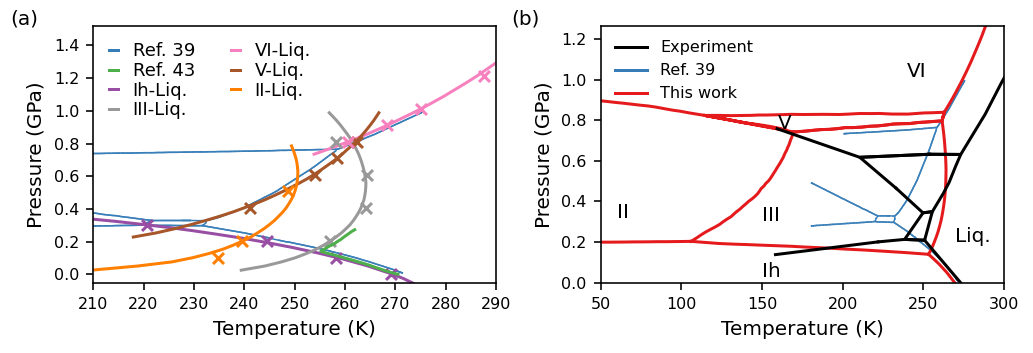

In [25]:
fig=plt.figure(figsize=(7.2,2.5))
ax = fig.add_subplot(121)
ax.add_artist(copy.copy(lines_tip4p_vega_data))
plt.plot(tip4p_vega_data2[:,0],tip4p_vega_data2[:,1],label='Ref. 43',color=color_dict['vega2'],zorder=3)


for i, key in enumerate(GibbsLines.keys()):
    lab=key.replace('Ice','').replace('Liquid','Liq.').replace('_','-')
    if "Liquid" not in key:
        continue
    #if i==0:
     #   plt.plot(GibbsLines[key][:,0],GibbsLines[key][:,1],color='b',label=lab)
    #else:
    ax.plot(GibbsLines[key][:,0],GibbsLines[key][:,1],color=color_dict_lines[key],label=lab)
    
for key in MeltingPoints.keys():
    ax.scatter(MeltingPoints[key][:,1],MeltingPoints[key][:,0],color=color_dict_lines[key],marker='x', s=30,zorder=3)


plt.ylabel('Pressure (GPa)')
plt.xlabel('Temperature (K)')
plt.ylim(bottom=-500*atm_to_gpa,top=15000*atm_to_gpa)
plt.xlim(left=210,right=290)
handles, labels = plt.gca().get_legend_handles_labels()

plt.legend(handles=[Line2D([0], [0], label='Ref. 39', color=color_dict['vega1'])]+handles,prop={'size': 9},ncol=2,frameon=False,handlelength=0.5,labelspacing=0.1)
plt.tight_layout()

ax = fig.add_subplot(122)
ax.add_artist(copy.copy(lines_tip4p_vega_data))
#ax.add_artist(copy.copy(lines_exp_liq))
plt.plot(St_GD_IceIh_Liquid[:,0],St_GD_IceIh_Liquid[:,1],color=color_dict['pd'],zorder=1,label='This work')
plt.plot(St_GD_IceIII_Liquid[:,0],St_GD_IceIII_Liquid[:,1],color=color_dict['pd'],zorder=1)
plt.plot(St_GD_IceV_Liquid[:,0],St_GD_IceV_Liquid[:,1],color=color_dict['pd'],zorder=1)
plt.plot(St_GD_IceVI_Liquid[:,0],St_GD_IceVI_Liquid[:,1],color=color_dict['pd'],zorder=1)
plt.plot(St_GD_IceII_IceIh[:,0],St_GD_IceII_IceIh[:,1],color=color_dict['pd'],zorder=1)

plt.plot(St_GD_IceIh_IceIII[:,0],St_GD_IceIh_IceIII[:,1],color=color_dict['pd'],zorder=1)
plt.plot(St_GD_IceII_IceIII[:,0],St_GD_IceII_IceIII[:,1],color=color_dict['pd'],zorder=1)
plt.plot(St_GD_IceVI_IceV[:,0],St_GD_IceVI_IceV[:,1],color=color_dict['pd'],zorder=1)
plt.plot(St_GD_IceII_IceV[:,0],St_GD_IceII_IceV[:,1],color=color_dict['pd'],zorder=1)
plt.plot(St_GD_IceII_IceVI[:,0],St_GD_IceII_IceVI[:,1],color=color_dict['pd'],zorder=1)
plt.plot(St_GD_IceV_IceIII[:,0],St_GD_IceV_IceIII[:,1],color=color_dict['pd'],zorder=1)
plt.plot(St_GD_IceV_IceIII[:,0],St_GD_IceV_IceIII[:,1],color=color_dict['pd'],zorder=1)

iceI=pd.read_csv('salzman/IceI.txt',delimiter='\t',header=None).to_numpy()[:,::-1]


iceIII=pd.read_csv('salzman/IceIII.txt',delimiter='\t',header=None).to_numpy()[:,::-1]
iceV=pd.read_csv('salzman/IceV.txt',delimiter='\t',header=None,na_values='--').to_numpy()[:,::-1]
iceVI=pd.read_csv('salzman/IceVI.txt',delimiter='\t',header=None).to_numpy()[:,::-1]

iceI[:,::2]+=273.15
iceIII[:,::2]+=273.15
iceV[:,::2]+=273.15
iceVI[:,::2]+=273.15
iceI[:,1::2]*=9869.23*atm_to_gpa
iceIII[:,1::2]*=9869.23*atm_to_gpa
iceV[:,1::2]*=9869.23*atm_to_gpa
iceVI[:,1::2]*=9869.23*atm_to_gpa
plt.plot(iceI[:,2],iceI[:,3],'k')
plt.plot(iceI[:,4],iceI[:,5],'k')

plt.plot(iceIII[:,0],iceIII[:,1],'k')
plt.plot(iceV[:,0],iceV[:,1],'k')
plt.plot(iceV[:,2],iceV[:,3],'k')
# remove other phases from the experimental phase diagram
keepT=iceVI[:,2]>150
keepP=iceVI[:,3]<10000*atm_to_gpa
keep=keepT*keepP
plt.plot(iceVI[keep,2],iceVI[keep,3],'k')
plt.plot(iceVI[:,4],iceVI[:,5],'k')

plt.xlim([0,300])
plt.annotate('Ih',(150,250*atm_to_gpa))#,color=color_dict['IceIh'])
plt.annotate('Liq.',(270,2000*atm_to_gpa))
plt.annotate('III',(150,3000*atm_to_gpa))#,color=color_dict['IceIII'])
plt.annotate('V',(160,7500*atm_to_gpa))#,color=color_dict['IceV'])
plt.annotate('II',(60,3150*atm_to_gpa))#,color=color_dict['IceII'])
plt.annotate('VI',(240,10000*atm_to_gpa))#,color=color_dict['IceVI'])
plt.ylabel('Pressure (GPa)')
plt.xlabel('Temperature (K)')
plt.legend()#prop={'size': 7},loc=2)
plt.xlim(left=50)
plt.ylim(top=12500*atm_to_gpa,bottom=0)
plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=[Line2D([0], [0], label='Experiment', color='k'),Line2D([0], [0], label='Ref. 39', color=color_dict['vega1'])]+handles,loc=2,frameon=False)
ax.annotate('(a)',xy=[0.01,0.93],xycoords='subfigure fraction')
ax.annotate('(b)',xy=[0.495,0.93],xycoords='subfigure fraction')

plt.savefig('figures/phase_diagrams.png',dpi=600)

## Plot all Gibbs-Duhem lines

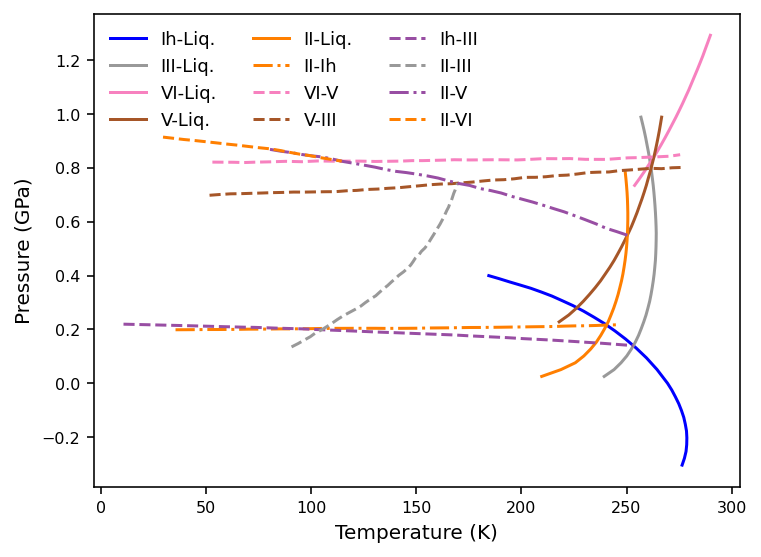

In [12]:
fig=plt.figure(figsize=(5.4,4))

for i, key in enumerate(GibbsLines.keys()):
    lab=key.replace('Ice','').replace('Liquid','Liq.').replace('_','-')
    if i==0:
        plt.plot(GibbsLines[key][:,0],GibbsLines[key][:,1],color='b',label=lab)
    else:
        plt.plot(GibbsLines[key][:,0],GibbsLines[key][:,1],color=color_dict_lines[key],ls=ls_dict_lines[key],label=lab)
plt.legend(ncol=3,loc=2,prop={'size': 9},frameon=False) 
plt.ylabel('Pressure (GPa)')
plt.xlabel('Temperature (K)')
plt.tight_layout()
plt.savefig('figures/GibbsLines.png',dpi=300)

## Store latex tables

### Triple points

In [22]:
with open('tables/triple_points.tex','w') as fp:
    fp.write('\\begin{tabular}{lrr}\n\\hline\\hline\n')
    fp.write('&P/GPa&T/K\\\\\n\\hline\n')
    for key in trip_pts:
        line='{}&{:.3f}&{:.2f}\\\\\n'.format(' - '.join(key.split()).replace('Ice', 'ice ').replace('Ih','I$_{\mathrm h}$'),trip_pts[key][1],trip_pts[key][0])
        fp.write(line)
    fp.write('\\hline\\hline\n\end{tabular}')
!cat tables/triple_points.tex

\begin{tabular}{lrr}
\hline\hline
&P/GPa&T/K\\
\hline
Liquid - ice III - ice V&0.798&261.67\\
Liquid - ice I$_{\mathrm h}$ - ice II&0.216&240.49\\
Liquid - ice V - ice VI&0.840&263.02\\
Liquid - ice III - ice I$_{\mathrm h}$&0.140&253.24\\
ice II - ice I$_{\mathrm h}$ - ice III&0.203&106.04\\
ice II - ice III - ice V&0.743&169.68\\
ice II - ice V - ice VI&0.825&114.54\\
Liquid - ice II - ice V&0.550&250.40\\
\hline\hline
\end{tabular}

### Melting points

In [24]:
with open('tables/MeltingPoints.tex','w') as fp:
    fp.write('\\begin{tabular}{lrrl}\n\\hline\\hline\n')
    fp.write('&P/GPa&T/K\\\\\n\\hline\n')
    for key in MeltingPoints.keys():
        line=''
        for i in range(len(MeltingPoints[key])):
            line+='{}&{:.3f}&{}\\\\\n'.format('-'.join(key.split('_')).replace('Ice', 'ice ').replace('Ih','I$_{\mathrm h}$'),MeltingPoints[key][i][0],MeltingPoints[key][i][1])
        fp.write(line+'\\hline\n')
    fp.write('\\hline\\hline\n\end{tabular}')
!cat tables/MeltingPoints.tex

\begin{tabular}{lrrl}
\hline\hline
&P/GPa&T/K\\
\hline
ice I$_{\mathrm h}$-Liquid&0.000&269.1\\
ice I$_{\mathrm h}$-Liquid&0.101&258.1\\
ice I$_{\mathrm h}$-Liquid&0.203&244.5\\
ice I$_{\mathrm h}$-Liquid&0.304&220.6\\
\hline
ice II-Liquid&0.101&234.8\\
ice II-Liquid&0.203&239.6\\
ice II-Liquid&0.507&248.6\\
\hline
ice III-Liquid&0.203&257.0\\
ice III-Liquid&0.405&264.1\\
ice III-Liquid&0.608&264.3\\
ice III-Liquid&0.811&258.2\\
\hline
ice V-Liquid&0.405&241.1\\
ice V-Liquid&0.608&254.0\\
ice V-Liquid&0.709&258.4\\
ice V-Liquid&0.811&262.4\\
\hline
ice VI-Liquid&0.811&260.5\\
ice VI-Liquid&0.912&268.3\\
ice VI-Liquid&1.013&275.1\\
ice VI-Liquid&1.216&287.6\\
\hline
\hline\hline
\end{tabular}